# Hopfield model project
Artificial Neural Networks (ANN) are computational techniques that aim to realize a very simplified model of the human brain. In this way, ANN try to learn tasks mimicking the behavior of brain. The brain is composed of a large set of elements, specialized cells called neurons. In analogy with the human brain, ANN are computational methods that use a large set of elementary computational: the neurons. Each single neuron is a very simple entity but the power of the brain is given by the fact that neurons are numerous and strongly interconnected between them. The human brain is one of the most computationally efficient device that is why in the late years a lot of effort has been done in order to develop an artificial version of it, as a matter of fact companies like Telsa motors are developing self driving cars which are based on ANN to implement the behavior of the human brain in computer systems. 

The easiest way to represent a neuron is either (on or off) or spin up/down in physics) with the synapsys either eccitative or inibitive. We can easily map the neural network into a spin system by mapping neurons in spins $\{s_i\}_{i=1,\cdots,N}$ and synapsys into the magnetic coupling $J_{ij}$.
By a specific representation of these coupling costant we can define the Hopfield model.

## The Hopfield Model
The Hopfield model is a fully connected neural network able to recall stored memories starting from a noisy or distorted input. The Hopfield network consists of N neurons connected through symmetric bidirectional links.The neuron interactions are encoded in the connection matrix, a N × N real symmetric matrix without self-interaction terms whose $J_{ij}$ entries define the weight of the connection between neuron i and j. 

The model respect the following mapping:

$$
n = \{0,1\} \longrightarrow s = \{-1,1\}      \mbox {     where n  is the binary operator and s the spin}
$$
                                   

The correct transformation of this mapping is:
$$
\begin{equation}
s = f(n) = \frac{2n-1}{2}
\end{equation}
$$
We define the synapses as:
$$
J_{ij}=\begin{cases}
+1 & \mbox{ excitatory synapses} \\
-1 & \mbox{ inhibitory synapses}
\end{cases}
$$

A neuron is activated if it receives a sufficient number of active impulsive, and we can compute these impulses as follows:
$$
\begin{equation}
h_i(t) = \sum^N_{j=1,j\neq i} J_{ij}(s_j(t)+1)
\label{eq:h} 
\end{equation}
$$
It is important to notice that $j\neq i$ since the neuron DOES NOT interacts with itself.
To decide if these impulses are sufficient to activate the neuron we apply a non-linear function to the impulses:
$$
\begin{equation}
s_i(t+1)=sign{\left(h_i(t)-\theta_i\right)}
\end{equation}
$$
where $\theta_i$ is the threshold. We choose this threshold in a way that is useful for the calculations:
$$
\theta_i = \sum^N_{j=1,j\neq i} J_{ij}.
$$
By applying this threshold we obtain in Equation $\eqref{eq:upd}$ $\textbf{update rule}$ that we will use below in the code:
$$
\begin{equation}
s_i(t+1)=sign{\left(\sum^N_{j=1,j\neq i} J_{ij}s_j(t)\right)}
\label{eq:upd}
\end{equation}
$$

The $\textbf{Hopfield model}$ that we will use in the following consists in a specific choice of the synapses (ferromagnetic couplings):
$$
\
\begin{equation}
\begin{cases}
J_{ii}=0 & \mbox{ known as Hebb rule} \\
J_{ij}=\frac{1}{N}\sum_{\mu=1}^{p} \xi^\mu_i\xi^\mu_j
\end{cases}
\label{eq:hop}
\end{equation}
$$
where the $\vec{\xi^\mu}$ are $p<<N$ excitatory pattern with $\xi^\mu_i=\{+1,-1\}$.
This choice encode these patterns in the couplings and gives to the system some interesting properties:
- if the system start from a configuration equal to a pattern $\vec{\xi^\mu}$ and apply the update rule of Eq $\eqref{eq:upd}$ it stays in that pattern $\forall t$.
- by solving the system from a statistical mechanics point of view turns out that the system has many minima and this minima are all and only the patterns.

The actual resolution of this system is quite long and it is not the aim of this work, but it is instructive to see the proof of the stability of the patterns.
$$
s(1)=sign{\left(\sum^N_{j=1} J_{ij}s_j(0)\right)}\overset{s_j(0)=\xi^\mu_j}{=}
sign{\left(\sum^N_{j=1} \frac{1}{N}\sum^p_{\nu=1}\xi_i^\nu\xi_j^\nu\xi_j^\mu\right)} 
\\=sign{\left(\sum^N_{\nu=1}\xi_i^\nu\frac{1}{N}\sum^p_{j=1}\xi_j^\nu\xi_j^\mu \right)} 
=sign{\left(\sum^N_{\nu=1}\xi_i^\nu(\delta_{\mu\nu}+O(N^{-\frac{1}{2}}) \right)}
\simeq sign\left(\xi^\mu_i \right)=\xi^\mu_i
$$
And so the property enuciated before holds.

From now on we will talk about spins and not neurons anymore.

This model take into account fully connected system, where each spin is connected to all the others. But what happen if we consider an interaction lenght $R$? It is an interesting question to look at how the results vary with this assumption.

It is also really interesting to notice that this type of system does not need training, and so it can be reallly interesting if the results are good.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp


In [66]:
# Parameters
L = 11   # Lenght of the edge of the image (change to 11?)
N = L**2 # Number of spins 
p = 10   # Number of patterns
MF = 0   # Use or not the Mean Field strategy: if MF=1 uses MF, if MF = 0 only spins at
         # a distance R interacts
R = 3    # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible

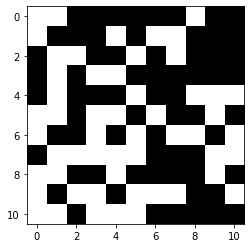

In [67]:
# Patterns
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

xi = random_patterns(N,p)
idx = np.random.randint(0,p)
plt.imshow(xi[idx].reshape(L,L),cmap='Greys') # This is an example of pattern 
# -1 = white, +1 = black

In [68]:
# Coupling constant
# Row i is the connections of the i-th neuron with the others.
# Note that the Hopfield model requires Jii=0
# Note that J is a symmetrical matrix (J=J.T)
def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J
def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 # Look at indexes should be ok -1
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

In [71]:
if MF: J = MF_coupling(xi,N)
else: J = R_coupling(xi,N,R)

In [72]:
# Update rule
def update(sys):
    N = len(sys)
    for i in range(N):
        temp = 0
        for j in range(N): #Maybe it is possible to set the cycle on J[i][j]!=0 only
            temp +=  J[i][j]*sys[j] 
        if temp == 0: temp = 2*np.random.randint(0,2)-1
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys, t):
    for i in range(t):
        sys = update(sys)
    return sys

def error_im(xi_idx, sys):
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys):
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct

def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction
    

The error of the algorithm is 0.090909
The algorithm recognised the pattern 5 and the correct pattern is 5


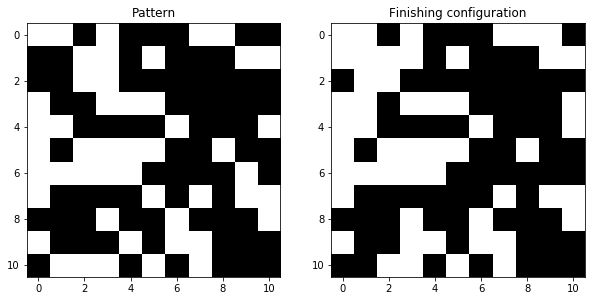

In [9]:
# actual algorithm
from copy import deepcopy
idx = np.random.randint(0,p)
sys = deepcopy(xi[idx])

sys = deterministic_hopfield(sys,100)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)

fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

## Analisys

In [8]:
# We now look at the scaling with regards to the parameters
L = 16
N = L**2

P = np.arange(5,N/2,20)
scores_16 = [[],[]]
errors_16 = [[],[]]

for MF in range(2):
    for p in P: 
        p = int(p)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        err, pred = total_error(xi,30)    
        scores_16[MF].append( pred )
        errors_16[MF].append(err)
       

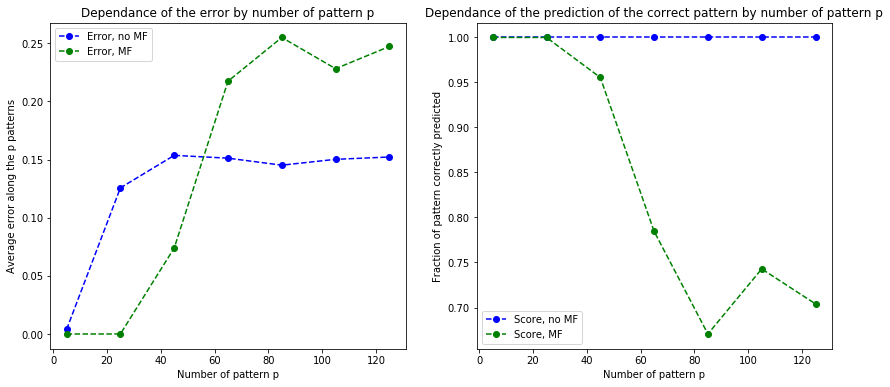

In [9]:
figp, axp = plt.subplots(1,2, figsize=(14,6))
axp[0].set_title('Dependance of the error by number of pattern p')
axp[0].set_xlabel('Number of pattern p')
axp[0].set_ylabel('Average error along the p patterns')
axp[0].plot(P,errors_16[0],  '--bo', label='Error, no MF')
axp[0].plot(P,errors_16[1], '--go', label='Error, MF')
axp[0].legend()

axp[1].set_title('Dependance of the prediction of the correct pattern by number of pattern p')
axp[1].set_xlabel('Number of pattern p')
axp[1].set_ylabel('Fraction of pattern correctly predicted')
axp[1].plot(P,scores_16[0], '--bo', label='Score, no MF')
axp[1].plot(P,scores_16[1], '--go', label='Score, MF')
axp[1].legend()

The dependance of error with patterns generally follows an increasing tendency at the beginning of the curve, which then flatters, reaching a plateau. The growth is particularly steep in the case of the Non Mean Field model, which reaches it maximum within the first $40$ $p$-patterns. It is instead is less pronounced for the Mean Field theory: here the highest value ($\approx 0.25$) is reached only after about $70$ patterns. The plateau of the Non Mean Field graph is, on the contrary, very stable, showing almost no oscillation around the value of $0.15$, which is also lower.

Concerning the dependence of the prediction of the correct pattern with number of patterns, it can be observed that, in case of Non Mean Field model, the score is always constant whichever the pattern, thus the independence of the error with  number of patterns and the perfect effectivness of the predictions. With the Mean Field model, however, this stability is not preserved: in fact, after passing the first few patterns, the score drops to about $70\%$, and oscillates around that value.

By observing both graphs, it can be stated that there exist an optimal value of $p$ patterns which optimize the performances of the algorithm, which in this case is around $20$ (about $8\%$ of the system size). In order to check if this tendency is preserved with other sizes of the system, different sizes are studied.


In [85]:
L = 10
N = L**2
P_10 = np.arange(5,N/2,5)
scores_10 = []
errors_10 = []
sigma_10 = []

MF = 0
for pi in P_10: 
    err = []
    pred = []
    for n in range(20):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_10.append( pred.std() )
    scores_10.append( pred.mean() )
    errors_10.append( err.mean() )

In [ ]:
figp, axp = plt.subplots(1,2, figsize=(14,6))
axp[0].set_title('Dependance of the error by number of pattern p')
axp[0].set_xlabel('Number of pattern p')
axp[0].set_ylabel('Average error along the p patterns')
axp[0].plot(P_10,errors_10,  '--co', label='Error, no MF, L =10')
axp[0].plot(P,errors_16[0],  '--bo', label='Error, no MF, L =16')
axp[0].legend() 

axp[1].set_title('Dependance of the prediction of the correct pattern by number of pattern p')
axp[1].set_xlabel('Number of pattern p')
axp[1].set_ylabel('Fraction of pattern correctly predicted')
axp[1].plot(P_10,scores_10, '--co', label='Score, no MF, L =10')
axp[1].plot(P,scores_16[0],  '--bo', label='Score, no MF, L =16')
axp[1].legend()

In [75]:
L = 6
N = L**2
P_6 = np.arange(2,N/2,1)
scores_6 = []
errors_6 = []
sigma_6 = []

MF = 0

for pi in P_6: 
    err = []
    pred = []
    for n in range(50):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_6.append( pred.std() )
    scores_6.append( pred.mean() )
    errors_6.append( err.mean() )

In [76]:
L = 8
N = L**2
P_8 = np.arange(2,N/2,2)
scores_8 = []
errors_8 = []
sigma_8 = []

MF = 0

for pi in P_8: 
    err = []
    pred = []
    for n in range(40):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_8.append( pred.std() )
    scores_8.append( pred.mean() )
    errors_8.append( err.mean() )


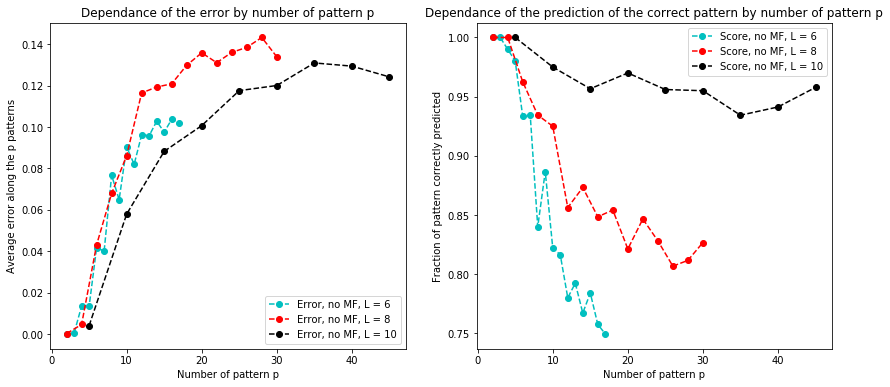

In [90]:
figp, axp = plt.subplots(1,2, figsize=(14,6))
axp[0].set_title('Dependance of the error by number of pattern p')
axp[0].set_xlabel('Number of pattern p')
axp[0].set_ylabel('Average error along the p patterns')
axp[0].plot(P_6,errors_6, '--co', label='Error, no MF, L = 6')
axp[0].plot(P_8,errors_8, '--ro', label='Error, no MF, L = 8')
axp[0].plot(P_10,errors_10, '--ko', label='Error, no MF, L = 10')
axp[0].legend() 

axp[1].set_title('Dependance of the prediction of the correct pattern by number of pattern p')
axp[1].set_xlabel('Number of pattern p')
axp[1].set_ylabel('Fraction of pattern correctly predicted')
axp[1].plot(P_6, scores_6, '--co', label='Score, no MF, L = 6')
axp[1].plot(P_8, scores_8, '--ro', label='Score, no MF, L = 8')
axp[1].plot(P_10, scores_10, '--ko', label='Score, no MF, L = 10')
axp[1].legend()

Comment these results
- optimal number of patterns <20, so % of system


In [15]:
# How does the time scales with the number of spins N?
import time as time
L = np.arange(10,28,4)
N = L**2 
p = 10
times = [[],[]]

for MF in range(2):
    for n in N:
        xi = np.random.randint(0,2,n*p).reshape(p,n)
        xi[xi==0]=-1
        J = 1/n * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(n) for j in range(n) ] )
        J = J.reshape(n,n)
        for k in range(len(J)):
            J[k,k] = 0
        idx = np.random.randint(0,p)
        start = time.time()
        deterministic_hopfield(xi[idx],30)
        end = time.time()
        times[MF].append(end-start)


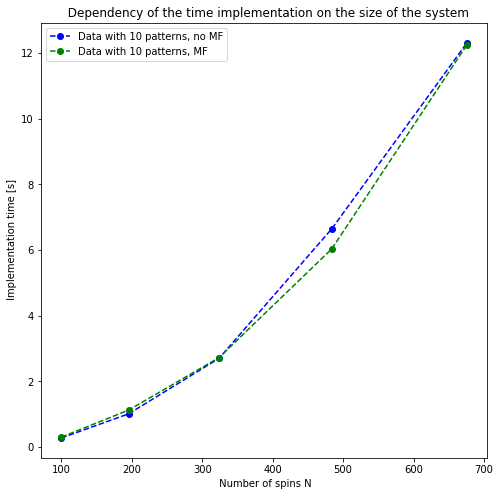

In [16]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(N,times[0], '--bo', label = 'Data with 10 patterns, no MF')
ax.plot(N,times[1], '--go', label = 'Data with 10 patterns, MF')
ax.set(xlabel = ' Number of spins N', ylabel =' Implementation time [s]', 
              title = '  Dependency of the time implementation on the size of the system')
ax.legend()

The two curves above show both an exponential growth of the implementation time as a function of the size of the system. The tendency does not change for both Mean Field and Non Mean Field models: this is consistent with the fact that the two algorithms are implemented with the same logic, just by changing the couplong rule.


The variation of implementation time with the number of spins follows a linear form with different slopes. Implementation time increases as the number of spins increases, for N in (500, 700), the implementation time increases slowly meaning that more time is required when a number of spins are used. In general the implementation time grows exponentially with number of spins.


In [17]:
# How does the time scales with the number of pattern p with a fixed N?

L = 16
N = L**2 
P = np.arange(10,N,16)
times = [[],[]]

for MF in range(2):
    for p in P:
        p = int(p)
        xi = np.random.randint(0,2,N*p).reshape(p,N)
        xi[xi==0]=-1
        J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
        J = J.reshape(N,N)
        for k in range(len(J)):
            J[k,k] = 0
        idx = np.random.randint(0,p)
        start = time.time()
        deterministic_hopfield(xi[idx],30)
        end = time.time()
        times[MF].append(end-start)



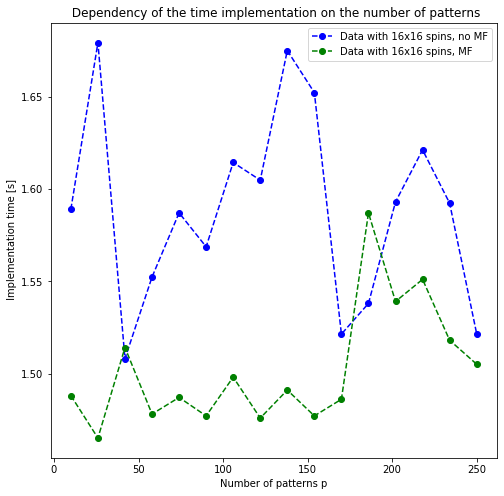

In [18]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(P,times[0], '--bo', label = 'Data with 16x16 spins, no MF')
ax.plot(P,times[1], '--go', label = 'Data with 16x16 spins, MF')
ax.set(xlabel = 'Number of patterns p', ylabel =' Implementation time [s]', 
              title = ' Dependency of the time implementation on the number of patterns')
ax.legend()

In this graph the implementation time ad a function of the number of patterns is displayed. The shape of the curve does not outline any particular tendency, and oscillates randomly showing instability.
The Mean Field model has less pronounced fluctuations with respect to the Non Mean Field one.

It can be concluded that the Non Mean Field model is more stable and leads to smaller errors, but is less computationally efficient with respect to the Mean Field one, which is unstable given the considerations stated in the cells above.

In [61]:
MF = 0
L = 10
N = L**2 
P = 10
error_R = [[],[]]
sigmas_R = [[],[]]
R = np.arange(3,L)

for MF in range(2):
    for r in R: 
        supp = []
        for n in range(50):
            xi = random_patterns(N,P)
            if MF: J = MF_coupling(xi,N)
            else: J = R_coupling(xi,N,r)
            err, pred = total_error(xi,30)    
            supp.append(err)
        supp = np.array(supp)
        error_R[MF].append(supp.mean())
        sigmas_R[MF].append(supp.std())


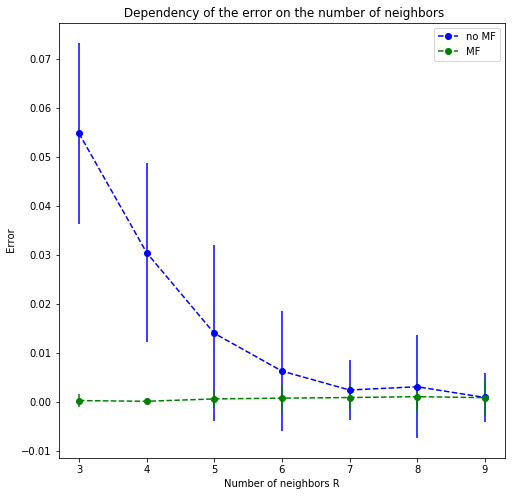

In [62]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(R,error_R[0], '--bo', label = 'no MF')
ax.errorbar(R,error_R[0], yerr=sigmas_R[0], fmt='none', color='b')
ax.plot(R,error_R[1], '--go', label = 'MF')
ax.errorbar(R,error_R[1], yerr=sigmas_R[1], fmt='none', color='g')

ax.set(xlabel = 'Number of neighbors R', ylabel =' Error ', 
              title = ' Dependency of the error on the number of neighbors')
ax.legend()


In [95]:
def w_error(sys11, sys22, alpha):
    sys1 = deepcopy(sys11)
    sys2 = deepcopy(sys22)
    N = sys1.shape[0]
    L = int(np.sqrt(N))
    sys1 = sys1.reshape(L,L)
    sys2 = sys2.reshape(L,L)
    wrong1 = []
    wrong2 = []
    min_dist = []
    for i in range(L):
        for j in range(L):
            if sys1[i][j] == sys2[i][j]: continue
            elif sys1[i][j]== 1 : 
                wrong1.append( np.array([i,j]) )
            elif sys2[i][j]== 1:
                wrong2.append( np.array([i,j]) )
    for i in wrong1:
        distances = []
        for j in wrong2:
            if np.linalg.norm(i-j) !=0 :
                distances.append( np.linalg.norm(i-j) )
        min_dist.append( np.array(distances).min() )
    min_dist = np.array(min_dist)
    err =  (1/(min_dist)**alpha).sum()
    return err
                

In [96]:
def plot(x, y, sys):
    L = int(np.sqrt(x.shape[0]))
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    ax[0].set_title('Original pattern')
    ax[0].imshow(x.reshape(L,L),cmap='Greys')
    ax[1].set_title('Corrupted pattern')
    ax[1].imshow(y.reshape(L,L),cmap='Greys')
    plt.show()

In [97]:
patt = [np.zeros(N)-1 for j in range(L)]
for i in range(L):
    for j in range(L):
        patt[i][i+L*j]=1

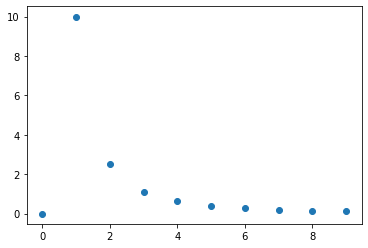

In [104]:
err = []
for i in patt:
    err.append(w_error(patt[0],i,2))

plt.scatter(np.arange(10),err)

In [99]:
p1 = np.zeros(N)-1
p1[0]=1
p2 = np.zeros(N)-1
p2[2]=1
p2[20]=1

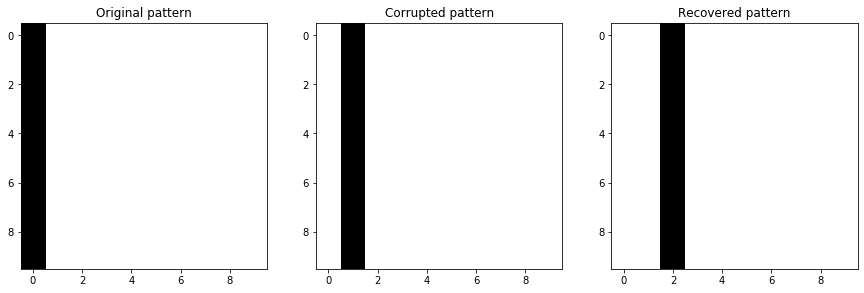

In [100]:
plot(patt[0],patt[1],patt[2])

In [101]:
w_error(p1,p2,2)

0.25